In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Processing
import numpy as np
np.random.seed(0)
import random
import json
import pandas as pd
from datetime import datetime, timedelta

import pickle
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder
import json

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from plotnine import ggplot, aes, geom_bar, theme_minimal, labs


# 项目结论

# Thinking Engine data


Dispute monitoring report:

http://td.winnerstudio.vip:8996/#/panel/panel/39_3423



## Time since payment and install

- Time since payment: http://td.winnerstudio.vip:8996/#/tga/ide/59_22269?tab=result

- Time since install: http://td.winnerstudio.vip:8996/#/tga/ide/59_22267


Next steps: 

- Can u find the dispute ID? 
- Then from that try to find out why a unique payment is associated to multiple rows? 
- Then check if after correcting this the join of predictions and regressors does not generate a movement in the rows of the response dataset. 
- Apply corrections across the analysis including the dashboards

# Response

In [3]:
# @title Function to pull data from the API
bs_token = 'lWYPGrEyZ0xqY7CJGTMx3DP60VBxZ21v7yrHjKguyGtQY2C5z16og6N8zu0R4Mbw'
host = 'td.winnerstudio.vip'

def pull_data(sql_script):

    data = {
        'token':          bs_token,
        'format':         'json_object',
        'timeoutSeconds': 1000,
        'sql':            sql_script
    }

    data = str(urlencode(data))
    response = requests.post(f'http://{host}:8992/querySql?{data}', timeout = 1000000)

    # Sample list of JSON strings
    json_list = response.text.split('\n')[1:]

    # Convert JSON strings to dictionaries
    dict_list = []
    for json_str in json_list:
        try:
            dict_list.append(json.loads(json_str))
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")

    # Create a pandas DataFrame
    data = pd.DataFrame(dict_list).sort_index(axis=1)

    # Display the DataFrame
    return data


The objective also is to find the measure of success. So the model needs to fit well the probabilities over time.

DECISION I 

- Consider only payments before the last 60 days: Reason, some of those payments can be succeptible of being disputed but hav enot been disputed yet. 
- Consider only payers that installed the game after september: Maybe before september it is too early 
- Acorn casino iOS: Only iOS version is active

In [4]:
RESPONSE_SQL = """

-- Payments (Payments with K month maturity). You can implement this to a later time.
with payment_aux as (
select *
from ta.v_event_59
where "$part_event" = 'order_pay'
    and  date_diff('day', "#event_time", current_date) < 60 -- Before the last 60 days
    and cast(date_format("#event_time", '%Y-%m-%d') as varchar) > '2023-11-01'
    and ("is_true" is null or "is_true" = true)
    and "$part_date" is not null)

-- Payments of users that have installed the app, after July last year (I want to filter to have users that installed), and are iOS devices.
-- Intersection of recently registered users and users that have made any of the payments above
, ios_payments as (
select
    a."#account_id"
    , b."register_time"
    , a."pay_id"
    , a."#event_time"                                               as "pay_time"
    , avg(if((c."#event_time" is not null), 1, 0))                  as "is_disputed"
from payment_aux as a
  join ta.v_user_59 as b                                                                                                  on a."#account_id" = b."#account_id"   and     a."#event_time" > b."register_time"
  left join (select * from ta.v_event_59 where "$part_event" = 'pay_dispute' and "$part_date" is not null) as c           on a.pay_id        = c.pay_id
where cast(date_format(b."register_time", '%Y-%m-%d') as varchar) > '2023-09-01'
  and b."bundle_id" = 'com.acorncasino.slots'
group by 1,2,3,4
)

select
    "#account_id"
    , "register_time"
    , avg("is_disputed") as dispute_rate
    , count(*)           as valid_payments
from ios_payments
group by 1,2

"""

In [5]:
response_data = pull_data(RESPONSE_SQL)

Error parsing JSON: Unterminated string starting at: line 1 column 88 (char 87)


In [6]:
response_data.sample(10)

,#account_id,dispute_rate,register_time,valid_payments
26351,10340229,0.0,2024-01-22 21:43:38.000,2
25067,10194025,0.0,2023-12-30 18:28:17.000,413
33796,10305049,0.0,2024-01-17 19:04:08.000,4
9645,10078852,0.0,2023-12-08 20:48:34.000,5
10469,10469621,0.0,2024-02-13 05:11:35.000,1
35450,10488694,0.0,2024-02-16 10:02:44.000,8
882,10422613,0.0,2024-02-05 07:49:18.000,12
40236,10294346,0.0,2024-01-16 00:12:35.000,32
1992,10112354,0.0,2023-12-15 07:16:25.000,2
37128,10353297,0.0,2024-01-24 22:13:57.000,2


### The more payments the more likely to dispute at least one

In [9]:
print('付费用户 count：  ', response_data[response_data['dispute_rate'] > 0].shape[0])
print('付费用户 with any dispute in 3 months：  ', response_data[response_data['dispute_rate'] > 0].shape[0] / response_data.shape[0])

付费用户 count：   547
付费用户 with any dispute in 3 months：   0.011262791607470093


In [10]:
print('付费用户 count：  ', response_data[response_data['valid_payments'] == 1][response_data['dispute_rate'] > 0].shape[0])
print('付费用户 with any dispute in 3 months：  ', response_data[response_data['valid_payments'] == 1][response_data['dispute_rate'] > 0].shape[0] / response_data[response_data['valid_payments'] == 1].shape[0])

付费用户 count：   118
付费用户 with any dispute in 3 months：   0.006462212486308872


In [11]:
print('付费用户 count：  ', response_data[response_data['valid_payments'] > 1][response_data['dispute_rate'] > 0].shape[0])
print('付费用户 with any dispute in 3 months：  ', response_data[response_data['valid_payments'] > 1][response_data['dispute_rate'] > 0].shape[0] / response_data[response_data['valid_payments'] > 1].shape[0])

付费用户 count：   429
付费用户 with any dispute in 3 months：   0.014155145675916456


In [12]:
print('付费用户 count：  ', response_data[response_data['valid_payments'] > 2][response_data['dispute_rate'] > 0].shape[0])
print('付费用户 with any dispute in 3 months：  ', response_data[response_data['valid_payments'] > 2][response_data['dispute_rate'] > 0].shape[0] / response_data[response_data['valid_payments'] > 2].shape[0])

付费用户 count：   376
付费用户 with any dispute in 3 months：   0.016404170847694254


### The more payments the less likely to dispute them all

In [13]:
print('付费用户 count：  ', response_data[response_data['dispute_rate'] > 0].shape[0])
print('付费用户 with any dispute in 3 months：  ', response_data[response_data['dispute_rate'] > 0].shape[0] / response_data.shape[0])

付费用户 count：   547
付费用户 with any dispute in 3 months：   0.011262791607470093


In [14]:
print('付费用户 count：  ', response_data[response_data['valid_payments'] == 1][response_data['dispute_rate'] == 1].shape[0])
print('付费用户 with any dispute in 3 months：  ', response_data[response_data['valid_payments'] == 1][response_data['dispute_rate'] == 1].shape[0] / response_data[response_data['valid_payments'] == 1].shape[0])

付费用户 count：   118
付费用户 with any dispute in 3 months：   0.006462212486308872


In [15]:
print('付费用户 count：  ', response_data[response_data['valid_payments'] > 1][response_data['dispute_rate'] == 1].shape[0])
print('付费用户 with any dispute in 3 months：  ', response_data[response_data['valid_payments'] > 1][response_data['dispute_rate'] == 1].shape[0] / response_data[response_data['valid_payments'] > 1].shape[0])

付费用户 count：   65
付费用户 with any dispute in 3 months：   0.0021447190418055237


In [16]:
print('付费用户 count：  ', response_data[response_data['valid_payments'] > 2][response_data['dispute_rate'] == 1].shape[0])
print('付费用户 with any dispute in 3 months：  ', response_data[response_data['valid_payments'] > 2][response_data['dispute_rate'] == 1].shape[0] / response_data[response_data['valid_payments'] > 2].shape[0])

付费用户 count：   46
付费用户 with any dispute in 3 months：   0.002006893242005148


# Measure of performance

So, it seems we want the model to find high probabilities, and those probabilities to be correctly fit. That is, to have some confidence.

Overall, 50 sample size is good for me.

We also want to see the performance over time. Try 3 months.

DECISION II: How to measure performance. Overall we want a system that can detect high probabilities. However we want those probabilities to be reliable. So we have to check them with new data. 

In [7]:
validation_sets = 3
response_data['date'] = pd.to_datetime(response_data['register_time']).apply(lambda x: int(x.strftime('%Y%m%d')))
response_data['validation_set_id'] = pd.qcut(response_data['date'].values, validation_sets)
response_data.groupby('validation_set_id').size()

validation_set_id
(20230901.999, 20240109.0]    14504
(20240109.0, 20240130.0]      13850
(20240130.0, 20240304.0]      13852
dtype: int64

DECISION III: Who is a disputer

In [8]:
response_data['disputer'] = (response_data['dispute_rate'] > 0).astype(int)
payment_cols = ['valid_payments', 'disputer']
response_data['disputer'].mean()

0.011514950480974269

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

def create_model(criterion, depth, leaf_size, cols):

    # preprocessor = ColumnTransformer(
    #     transformers = [
    #         ('scaler', StandardScaler(), cols)
    #     ],
    #     remainder='passthrough'
    # )

    # Create the pipeline
    pipe = Pipeline([
        # ('preprocessor', preprocessor),
        ('regressor', DecisionTreeClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
        # ('regressor', RandomForestClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
    ])

    return pipe


In [10]:
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score


model_results = []
all_model_results = []
criteria = ['gini', 'entropy', 'log_loss']
criteria = ['gini']
depths = [10, 11]
leaf_sizes = [10, 20, 30]
cols = ['valid_payments']

# for train_index, test_index in splits:
for date_group in response_data['validation_set_id'].unique():

    train_data =  response_data[response_data['validation_set_id'] != date_group][payment_cols]
    test_data =  response_data[response_data['validation_set_id'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
    X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

    # old_cols = X_train.copy().columns
    # X_train = all_feature_enginerring(X_train, y_train)
    # X_test = all_feature_enginerring(X_test, y_test)

    for criterion in tqdm(criteria):

        for depth in depths:

            for leaf_size in leaf_sizes:

              model = create_model(criterion, depth, leaf_size, cols)

              try:
                  model.fit(X_train[cols], y_train)
                  predictions = model.predict(X_test[cols])
                  accuracy = accuracy_score(y_test, predictions)
                  prec = precision_score(y_test, predictions)

              except:
                  model = np.nan
                  predictions = np.nan
                  mae = np.nan
                  r2 = np.nanZ

              predictions = model.predict_proba(X_test[cols])

              # Save the model into dictionary (Response, day, mo...)
              model_result = pd.DataFrame({
                  'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)]
                  , 'Test at': [date_group]
                  , 'Model': [model]
                  , 'accuracy': [accuracy]
                  , 'precission': [prec]
                  # , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
              })

              model_results.append(model_result)

    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


In [11]:
(1 - predictions[:, 0]).max()

0.19999999999999996

In [12]:
amrgb = all_model_results.groupby('Iteration')[['accuracy', 'precission']].mean().sort_values(by = 'accuracy', ascending = False).reset_index(drop = False)
amrgb

,Iteration,accuracy,precission
0,gini - 10 - 10,0.986593,0.0
1,gini - 10 - 20,0.986593,0.0
2,gini - 10 - 30,0.986593,0.0
3,gini - 11 - 10,0.986593,0.0
4,gini - 11 - 20,0.986593,0.0
5,gini - 11 - 30,0.986593,0.0


In [13]:
best_clf = all_model_results[all_model_results['Iteration'] == 'gini - 10 - 10']['Model'].values[0]
# selected_indices = all_model_results[all_model_results['Iteration'] == 'log_loss - 5 - 20']['Model'].values[0][1]['step_1']
best_clf

Pipeline(steps=[('regressor',
                 DecisionTreeClassifier(max_depth=10, min_samples_leaf=10))])

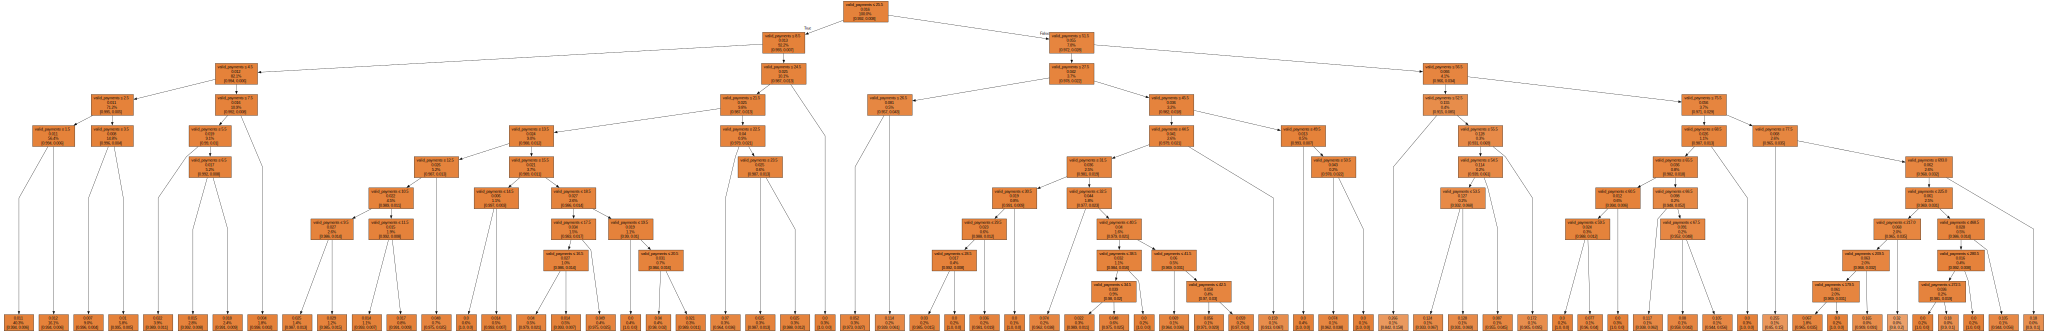

In [15]:
# Before the import statements
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'  # Adjust the path as per your Graphviz installation

# Your existing code
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# The rest of your code


# Create the decision tree classifier
# clf = all_model_results[all_model_results['Iteration'] == 'gini - 10 - 10']['Model'].values[0][1]
clf = all_model_results[all_model_results['Iteration'] == 'gini - 10 - 10']['Model'].values[0][0]

# Train the classifier with your data

# Assuming you have your data stored in X_train and y_train
# clf.fit(X_train, y_train)

# Visualize the decision tree
dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = cols
                          #  ,  class_names=True
                           ,  label = 'none'
                           ,  filled=True
                           ,  leaves_parallel = True
                           ,  proportion = True
                           ,  rounded=False
                           ,  special_characters=True)

graphviz.Source(dot_data)


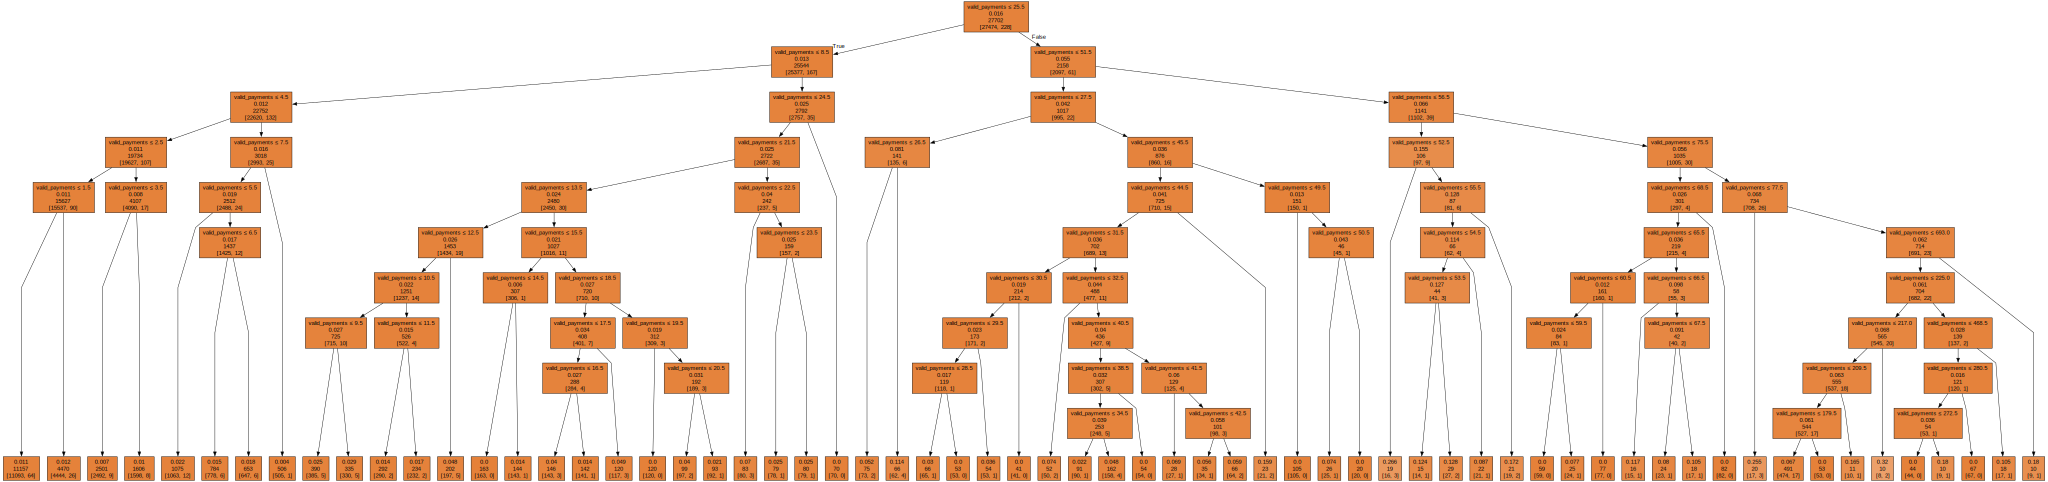

In [16]:
# Visualize the decision tree
dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = cols
                          #  ,  class_names=True
                           ,  label = 'none'
                           ,  filled = True
                           ,  leaves_parallel = True
                           ,  proportion = False
                           ,  rounded = False
                           ,  special_characters = True)

graphviz.Source(dot_data)

The next thing is that the model needs to make sense. I don't want to use the behavior after disputing right? So you need to look at the behaviour in a particular moment in time.

# Predictors

Pull and join them. It is okay.

 - You can use basic PLTV data: Withdrawal, etc.
 - Activity

In [17]:

# I am getting all the payers. Making a any payment after Novemeber. And making any payment before the last 60 days. 
# Then, I am truncating them 

RESPONSE_SQL = """

-- Payments (Payments with K month maturity). You can implement this to a later time.
with payment_aux as (
select *
from ta.v_event_59
where "$part_event" = 'order_pay'
    and  date_diff('day', "#event_time", current_date) < 60 -- Before the last 60 days
    and cast(date_format("#event_time", '%Y-%m-%d') as varchar) > '2023-11-01'
    and ("is_true" is null or "is_true" = true)
    and "$part_date" is not null)

-- Payments of users that have installed the app, after July last year (I want to filter to have users that installed), and are iOS devices.
-- Intersection of recently registered users and users that have made any of the payments above
, ios_payments as (
select
    a."#account_id"
    , b."register_time"
    , a."pay_id"
    , a."#event_time"                                               as "pay_time"
    , avg(if((c."#event_time" is not null), 1, 0))                  as "is_disputed"
from payment_aux as a
  join ta.v_user_59 as b                                                                                                  on a."#account_id" = b."#account_id"   and     a."#event_time" > b."register_time"
  left join (select * from ta.v_event_59 where "$part_event" = 'pay_dispute' and "$part_date" is not null ) as c           on a.pay_id        = c.pay_id
where cast(date_format(b."register_time", '%Y-%m-%d') as varchar) > '2023-09-01'
  and b."bundle_id" = 'com.acorncasino.slots'
group by 1,2,3,4
)

select
    "#account_id"
    , "register_time"
    , avg("is_disputed") as dispute_rate
    , count(*)           as valid_payments
from ios_payments
group by 1,2

"""

In [18]:
"""
# @title SQL Tables
"""

today = datetime.today()
start_date = '2023-09-01'
end_date = today - timedelta(days = 60)


import types

USER_PAYMENT = f"""
with payment_aux as (
select "#event_time", "pay_enter_name", "payment_type","#account_id", "#os", cast("net_amount" as double) as na
from ta.v_event_59
where "$part_event" = 'order_pay'
    and  date_diff('day', "#event_time", current_date) < 60 -- Before the last 60 days
    and cast(date_format("#event_time", '%Y-%m-%d') as varchar) > '2023-11-01'
    and ("is_true" is null or "is_true" = true)
    and "$part_date" is not null)

select
a."#account_id"
,cast(date_format(date_add('hour', 8, a."register_time"),'%Y-%m-%d') as varchar) as "register_time"
,sum(if(date_diff('day',a."register_time",b."#event_time")<=35,na,0))            as p35
,sum(if(date_diff('day',a."register_time",b."#event_time")<=42,na,0))            as p42
,sum(if(date_diff('day',a."register_time",b."#event_time")<=49,na,0))            as p49
,sum(if(date_diff('day',a."register_time",b."#event_time")<=56,na,0))            as p56
,sum(if(date_diff('day',a."register_time",b."#event_time")<=91,na,0))            as p91
,sum(if(date_diff('day',a."register_time",b."#event_time")<=133,na,0))           as p133
,sum(if(date_diff('day',a."register_time",b."#event_time")<=28,na,0))            as p28
,sum(if(date_diff('day',a."register_time",b."#event_time")<=14,na,0))            as p14
,sum(if(date_diff('day',a."register_time",b."#event_time")<=7,na,0))             as p7
,sum(if(date_diff('day',a."register_time",b."#event_time")<=6,na,0))             as p6
,sum(if(date_diff('day',a."register_time",b."#event_time")<=5,na,0))             as p5
,sum(if(date_diff('day',a."register_time",b."#event_time")<=4,na,0))             as p4
,sum(if(date_diff('day',a."register_time",b."#event_time")<=3,na,0))             as p3
,sum(if(date_diff('day',a."register_time",b."#event_time")<=2,na,0))             as p2
,sum(if(date_diff('day',a."register_time",b."#event_time")<=1,na,0))             as p1
,sum(if(date_diff('hour',a."register_time",b."#event_time")<=6,na,0))            as ph6
,sum(if(date_diff('hour',a."register_time",b."#event_time")<=1,na,0))            as ph1
,sum(if(date_diff('day',a."register_time",b."#event_time")<=7,1,0))              as cp7
,sum(if(date_diff('day',a."register_time",b."#event_time")<=3,1,0))              as cp3
,sum(if(date_diff('day',a."register_time",b."#event_time")<=1,1,0))              as cp1
from ta.v_user_59 as a
  left join payment_aux as b
    on a."#account_id" = b."#account_id"
    and a."register_time" < b."#event_time"
    and date_diff('day', a."register_time", b."#event_time") <= 90
where cast(date_format(a."register_time", '%Y-%m-%d') as varchar) > '2023-09-01'
  and a."bundle_id" = 'com.acorncasino.slots'
group by 1,2
"""

WITHDRAWALS = f"""

with cash_withdrawals_success as (
select "#account_id","withdraw_id","#event_time","amount","withdraw_fee"
from v_event_59 where "$part_event"='withdraw_success' and "$part_date" is not null)

, cash_withdrawals_applied as (
select "#account_id","withdraw_id","#event_time","amount","withdraw_fee"
from v_event_59 where "$part_event"='withdraw_apply' and "$part_date" is not null)

, withdrawals_aux as (
select
 a."#account_id"
 , a."withdraw_id"
 , a."#event_time"                      as withdrawal_apply_time
 , a."amount" - a."withdraw_fee"        as withdrawal_amount
 , b."#event_time"                      as ws_t
 , b."amount" - b."withdraw_fee"        as withdrawal_succes_amount
 , b."amount"                           as wa
from cash_withdrawals_applied a
  left join cash_withdrawals_success b on a."withdraw_id" = b."withdraw_id")

select
 a."#account_id"
 ,sum(if(date_diff('day',a."register_time",ws_t)<=28,wa,0)) as w28
 ,sum(if(date_diff('day',a."register_time",ws_t)<=27,wa,0)) as w27
 ,sum(if(date_diff('day',a."register_time",ws_t)<=26,wa,0)) as w26
 ,sum(if(date_diff('day',a."register_time",ws_t)<=25,wa,0)) as w25
 ,sum(if(date_diff('day',a."register_time",ws_t)<=24,wa,0)) as w24
 ,sum(if(date_diff('day',a."register_time",ws_t)<=23,wa,0)) as w23
 ,sum(if(date_diff('day',a."register_time",ws_t)<=22,wa,0)) as w22
 ,sum(if(date_diff('day',a."register_time",ws_t)<=21,wa,0)) as w21
 ,sum(if(date_diff('day',a."register_time",ws_t)<=20,wa,0)) as w20
 ,sum(if(date_diff('day',a."register_time",ws_t)<=19,wa,0)) as w19
 ,sum(if(date_diff('day',a."register_time",ws_t)<=18,wa,0)) as w18
 ,sum(if(date_diff('day',a."register_time",ws_t)<=17,wa,0)) as w17
 ,sum(if(date_diff('day',a."register_time",ws_t)<=16,wa,0)) as w16
 ,sum(if(date_diff('day',a."register_time",ws_t)<=15,wa,0)) as w15
 ,sum(if(date_diff('day',a."register_time",ws_t)<=14,wa,0)) as w14
 ,sum(if(date_diff('day',a."register_time",ws_t)<=13,wa,0)) as w13
 ,sum(if(date_diff('day',a."register_time",ws_t)<=12,wa,0)) as w12
 ,sum(if(date_diff('day',a."register_time",ws_t)<=11,wa,0)) as w11
 ,sum(if(date_diff('day',a."register_time",ws_t)<=10,wa,0)) as w10
 ,sum(if(date_diff('day',a."register_time",ws_t)<=9,wa,0))  as w9
 ,sum(if(date_diff('day',a."register_time",ws_t)<=8,wa,0))  as w8
 ,sum(if(date_diff('day',a."register_time",ws_t)<=7,wa,0))  as w7
 ,sum(if(date_diff('day',a."register_time",ws_t)<=3,wa,0))  as w3
 ,sum(if(date_diff('day',a."register_time",ws_t)<=1,wa,0))  as w1
from ta.v_user_59 a
   left join withdrawals_aux b
	on a."#account_id"=b."#account_id"
	and a."register_time" < ws_t
	and ws_t < date_add('day', 30, a."register_time")
where cast(date_format(date_add('hour', 8, "register_time"), '%Y-%m-%d') as varchar) between '{start_date}' and '{end_date}'
  and a."bundle_id" = 'com.acorncasino.slots'
group by 1
"""

PLAYERS_BEHAVIOUR = f"""
with players_aux as (
select  "#account_id", "game_id", "#event_time"
from v_event_59
  where "$part_event" = 'game_start'
  and "$part_date" is not null)

select
 a."#account_id"
 , count(distinct case when DATE_DIFF('DAY',a."register_time", b."#event_time")  <= 7  then "game_id" else null end) as games_played_d7
 , count(distinct case when DATE_DIFF('DAY',a."register_time", b."#event_time")  <= 6  then "game_id" else null end) as games_played_d6
 , count(distinct case when DATE_DIFF('DAY',a."register_time", b."#event_time")  <= 5  then "game_id" else null end) as games_played_d5
 , count(distinct case when DATE_DIFF('DAY',a."register_time", b."#event_time")  <= 4  then "game_id" else null end) as games_played_d4
 , count(distinct case when DATE_DIFF('DAY',a."register_time", b."#event_time")  <= 3  then "game_id" else null end) as games_played_d3
 , count(distinct case when DATE_DIFF('DAY',a."register_time", b."#event_time")  <= 2  then "game_id" else null end) as games_played_d2
 , count(distinct case when DATE_DIFF('DAY',a."register_time", b."#event_time")  <= 1  then "game_id" else null end) as games_played_d1
 , count(distinct case when DATE_DIFF('hour',a."register_time", b."#event_time") <= 1 then "game_id" else null end) as games_played_h1
from ta.v_user_59 as a
  left join players_aux as b
    on a."#account_id" = b."#account_id" and a."register_time" < b."#event_time"
    and date_diff('day', a."register_time", b."#event_time") <= 30
where cast(date_format(date_add('hour', 8, "register_time"), '%Y-%m-%d') as varchar) between '{start_date}' and '{end_date}'
  and a."bundle_id" = 'com.acorncasino.slots'
group by 1, a."register_time"
"""

CURRENCY_STATUS = f"""
with currency_status_aux as (
select
   "#account_id"
    , "#event_time"
    , coin_change
    , bonus_change
    , money_change
from v_event_59
WHERE "$part_event" = 'currency_change'
    and "$part_date" is not null)
select
     a."#account_id"
     , sum(case when date_diff('minute', a."register_time", b."#event_time") <= 7*24*60 then coin_change else 0 end)   as coin_status_d7
     , sum(case when date_diff('minute', a."register_time", b."#event_time") <= 7*24*60 then bonus_change else 0 end)  as bonus_status_d7
     , sum(case when date_diff('minute', a."register_time", b."#event_time") <= 7*24*60 then money_change else 0 end)  as money_status_d7

     , sum(case when date_diff('minute', a."register_time", b."#event_time") <= 3*24*60 then coin_change else 0 end)   as coin_status_d3
     , sum(case when date_diff('minute', a."register_time", b."#event_time") <= 3*24*60 then bonus_change else 0 end)  as bonus_status_d3
     , sum(case when date_diff('minute', a."register_time", b."#event_time") <= 3*24*60 then money_change else 0 end)  as money_status_d3

     , sum(case when date_diff('minute', a."register_time", b."#event_time") <= 24*60  then coin_change else 0 end)    as coin_status_d1
     , sum(case when date_diff('minute', a."register_time", b."#event_time") <= 24*60  then bonus_change else 0 end)   as bonus_status_d1
     , sum(case when date_diff('minute', a."register_time", b."#event_time") <= 24*60  then money_change else 0 end)   as money_status_d1
from ta.v_user_59 as a
    left join currency_status_aux as b
        on a."#account_id" = b."#account_id"
        and a."register_time" < b."#event_time"
where cast(date_format(date_add('hour', 8, "register_time"), '%Y-%m-%d') as varchar) between '{start_date}' and '{end_date}'
  and a."bundle_id" = 'com.acorncasino.slots'
group by 1, a."register_time"
"""

ADVERTISING_REVENUE = f"""
select
     a."#account_id"
    ,sum(if(date_diff('day',a."register_time",b."#event_time")<=28,b."revenue",0))  as ad28
    ,sum(if(date_diff('day',a."register_time",b."#event_time")<=7,b."revenue",0))   as ad7
    ,sum(if(date_diff('day',a."register_time",b."#event_time")<=6,b."revenue",0))   as ad6
    ,sum(if(date_diff('day',a."register_time",b."#event_time")<=5,b."revenue",0))   as ad5
    ,sum(if(date_diff('day',a."register_time",b."#event_time")<=4,b."revenue",0))   as ad4
    ,sum(if(date_diff('day',a."register_time",b."#event_time")<=3,b."revenue",0))   as ad3
    ,sum(if(date_diff('day',a."register_time",b."#event_time")<=2,b."revenue",0))   as ad2
    ,sum(if(date_diff('day',a."register_time",b."#event_time")<=1,b."revenue",0))   as ad1
from ta.v_user_59 as a
left join (select "#account_id", "#event_time", "revenue" from v_event_59 where  "$part_event"='ad_done' and "$part_date" is not null) as b
  on a."#account_id" = b."#account_id"
  and a."register_time" < b."#event_time"
  and date_diff('day', a."register_time", b."#event_time") <= 30
where cast(date_format(date_add('hour', 8, "register_time"), '%Y-%m-%d') as varchar) between '{start_date}' and '{end_date}'
  and a."bundle_id" = 'com.acorncasino.slots'
group by 1, a."register_time"
"""

global_symbols = globals()
tables = [USER_PAYMENT]



In [19]:
"""
# @title Data load
"""

def load_data(tables, bs_token, host):
    def pull_data(sql_script, bs_token, host):

        data = {
            'token':          bs_token,
            'format':         'json_object',
            'timeoutSeconds': 2000,
            'sql':            sql_script
        }

        data = str(urlencode(data))
        response = requests.post(f'http://{host}:8992/querySql?{data}', timeout = 1000000)

        # Sample list of JSON strings
        json_list = response.text.split('\n')[1:]

        # Convert JSON strings to dictionaries
        dict_list = []
        for json_str in json_list:
            try:
                dict_list.append(json.loads(json_str))
            except json.JSONDecodeError as e:
                print(f"Error parsing JSON: {e}")

        # Create a pandas DataFrame
        data = pd.DataFrame(dict_list).sort_index(axis = 1)
        print(data)
        # Display the DataFrame
        return data

    # Load the first data using USER_PAYMENT, and then iteatevely join the remaining data for trainning

    df = pull_data(tables[0], bs_token, host)
    for i in range(1, len(tables)):
        response_data = pull_data(tables[i], bs_token, host)
        df = df.merge(response_data, on = '#account_id', how = 'left')

    return df

# Create df by loading information and joining on account_id
predictors = load_data(tables, bs_token, host)


Error parsing JSON: Expecting value: line 1 column 1 (char 0)
       #account_id  cp1  cp3  cp7      p1     p133     p14      p2      p28  \
0         10001890    0    0    0   0.000    0.000   0.000   0.000    0.000   
1         10004778    0    0    0   0.000    0.000   0.000   0.000    0.000   
2         10005267    0    0    0   0.000    0.000   0.000   0.000    0.000   
3         10005565    0    0    0   0.000    0.000   0.000   0.000    0.000   
4         10005734    0    0    0   0.000    0.000   0.000   0.000    0.000   
...            ...  ...  ...  ...     ...      ...     ...     ...      ...   
524734    10415542    7    7    7  20.024   20.024  20.024  20.024   20.024   
524735    10415632    0    0    0   0.000    0.842   0.000   0.000    0.842   
524736    10416262    0    0    0   0.000    0.000   0.000   0.000    0.000   
524737    10416327    0    0    0   0.000    0.000   0.000   0.000    0.000   
524738    10416498    4    4    6  65.540  146.794  90.574  65.540  1

In [20]:
print(predictors.shape)
predictors.sample(10)

(524739, 22)


,#account_id,cp1,cp3,cp7,p1,p133,p14,p2,p28,p3,...,p42,p49,p5,p56,p6,p7,p91,ph1,ph6,register_time
120147,10451950,0,0,0,0.0,0.000,0.000,0.0,0.000,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,2024-02-10
329125,10457502,0,0,0,0.0,0.000,0.000,0.0,0.000,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,2024-02-11
264481,10471669,0,0,1,0.0,1.784,1.784,0.0,1.784,0.00,...,1.784,1.784,1.784,1.784,1.784,1.784,1.784,0.0,0.0,2024-02-14
306816,10106245,0,0,0,0.0,0.000,0.000,0.0,0.000,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,2023-12-14
413069,10121393,0,0,0,0.0,0.000,0.000,0.0,0.000,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,2023-12-17
172402,10075912,0,0,0,0.0,0.000,0.000,0.0,0.000,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,2023-12-08
195597,10204862,0,1,5,0.0,95.740,77.250,0.0,77.250,18.82,...,77.250,95.740,46.600,95.740,46.600,49.170,95.740,0.0,0.0,2024-01-02
244369,10443993,0,0,0,0.0,0.000,0.000,0.0,0.000,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,2024-02-09
434005,10083521,0,0,0,0.0,0.000,0.000,0.0,0.000,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,2023-12-10
199131,10341289,0,0,0,0.0,0.000,0.000,0.0,0.000,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,2024-01-23


In [21]:
response_data.shape

(42206, 7)

In [22]:
result = pd.merge(response_data, predictors, on = '#account_id', how = 'inner')

In [23]:
result.shape

(42206, 28)

In [ ]:
# Trainn

# Trainning

In [24]:
cols = ['valid_payments', 'p3', 'p7', 'p14', 'p28']

In [25]:
validation_sets = 3
result['date'] = pd.to_datetime(result['register_time_x']).apply(lambda x: int(x.strftime('%Y%m%d')))
result['validation_set_id'] = pd.qcut(result['date'].values, validation_sets)
# result['validation_set_id'] = 1
result.groupby('validation_set_id').size()

validation_set_id
(20230901.999, 20240109.0]    14504
(20240109.0, 20240130.0]      13850
(20240130.0, 20240304.0]      13852
dtype: int64

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

def create_model(criterion, depth, leaf_size, cols):

    # preprocessor = ColumnTransformer(
    #     transformers = [
    #         ('scaler', StandardScaler(), cols)
    #     ],
    #     remainder='passthrough'
    # )

    # Create the pipeline
    pipe = Pipeline([
        # ('preprocessor', preprocessor),
        ('regressor', DecisionTreeClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
        # ('regressor', RandomForestClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
    ])

    return pipe


In [27]:
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score


model_results = []
all_model_results = []
criteria = ['gini', 'entropy', 'log_loss']
depths = [4,5,6, 7]
leaf_sizes = [200]
cols = ['valid_payments', 'p3', 'p7', 'p14', 'p28']
payment_cols = cols + ['disputer']
# for train_index, test_index in splits:
for date_group in result['validation_set_id'].unique():

    train_data =  result[result['validation_set_id'] != date_group][payment_cols]
    test_data =  result[result['validation_set_id'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
    X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

    # old_cols = X_train.copy().columns
    # X_train = all_feature_enginerring(X_train, y_train)
    # X_test = all_feature_enginerring(X_test, y_test)

    for criterion in tqdm(criteria):

        for depth in depths:

            for leaf_size in leaf_sizes:

              model = create_model(criterion, depth, leaf_size, cols)

              model.fit(X_train[cols], y_train)
              predictions = model.predict(X_test[cols])
              accuracy = accuracy_score(y_test, predictions)
              prec = precision_score(y_test, predictions)

              # try:
              #     model.fit(X_train[cols], y_train)
              #     predictions = model.predict(X_test[cols])
              #     accuracy = accuracy_score(y_test, predictions)
              #     prec = precision_score(y_test, predictions)

              # except:
              #     model = np.nan
              #     predictions = np.nan
              #     mae = np.nan
              #     r2 = np.nan

              # Save the model into dictionary (Response, day, mo...)
              model_result = pd.DataFrame({
                  'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)]
                  , 'Test at': [date_group]
                  , 'Model': [model]
                  , 'accuracy': [accuracy]
                  , 'precission': [prec]
                  # , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
              })

              model_results.append(model_result)

    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  5.54it/s]


In [28]:
# all_model_results.groupby(['Iteration', 'Test at', 'Model']).mean()
amrgb = all_model_results.groupby('Iteration')[['accuracy', 'precission']].mean().sort_values(by = 'accuracy', ascending = False).reset_index(drop = False)
amrgb


,Iteration,accuracy,precission
0,entropy - 4 - 200,0.986593,0.0
1,entropy - 5 - 200,0.986593,0.0
2,entropy - 6 - 200,0.986593,0.0
3,entropy - 7 - 200,0.986593,0.0
4,gini - 4 - 200,0.986593,0.0
5,gini - 5 - 200,0.986593,0.0
6,gini - 6 - 200,0.986593,0.0
7,gini - 7 - 200,0.986593,0.0
8,log_loss - 4 - 200,0.986593,0.0
9,log_loss - 5 - 200,0.986593,0.0


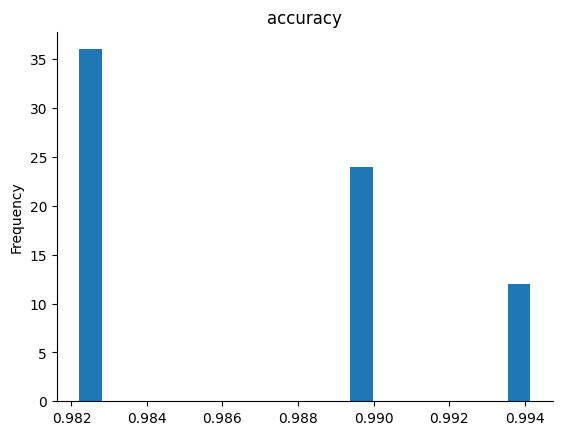

In [29]:
# @title accuracy

from matplotlib import pyplot as plt
all_model_results['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

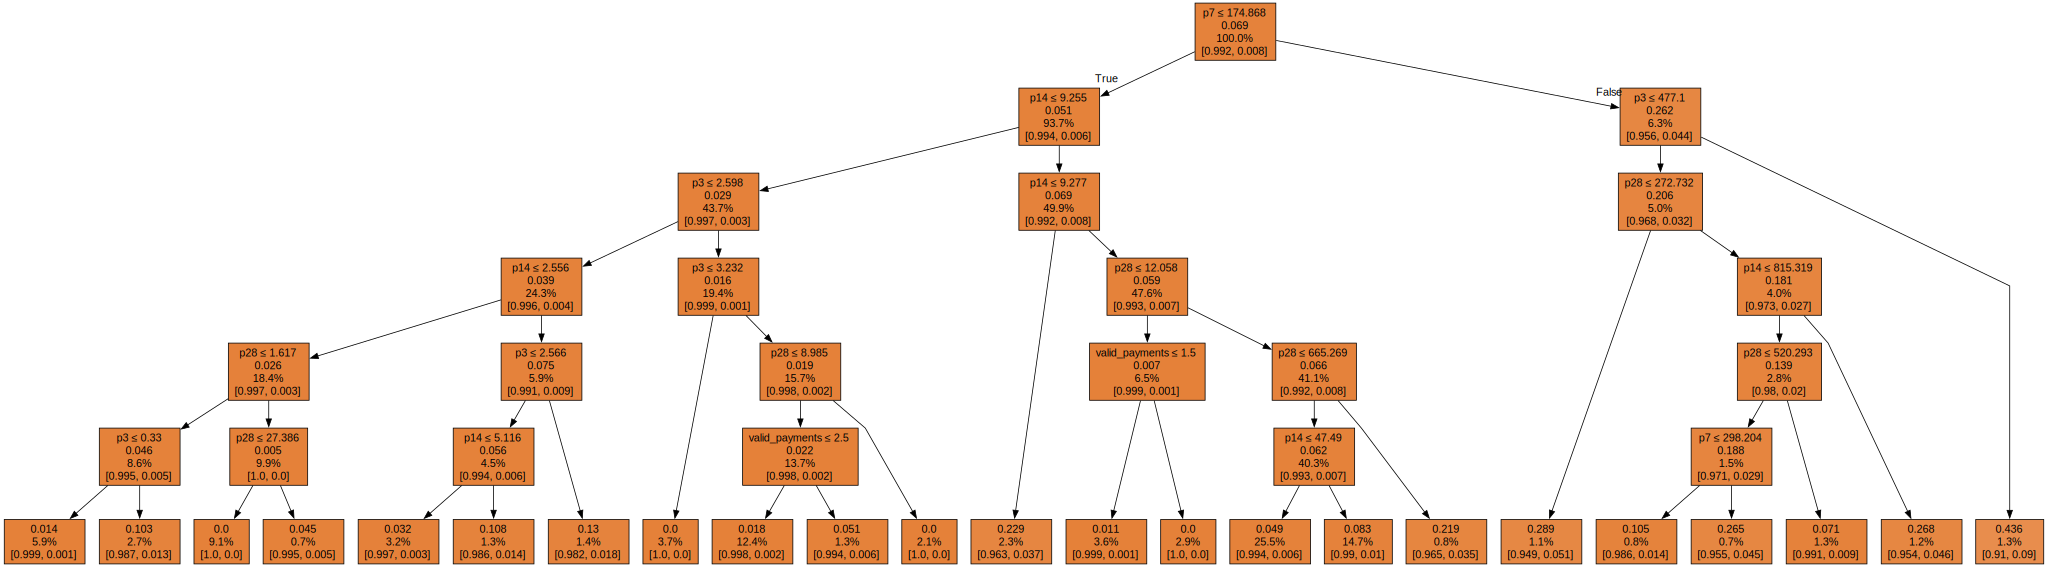

In [30]:
# from sklearn import tree
# from sklearn.tree import DecisionTreeClassifier, export_graphviz
# import graphviz

# Create the decision tree classifier
clf = all_model_results[all_model_results['Iteration'] == 'log_loss - 6 - 200']['Model'].values[0][0]

# Train the classifier with your data

# Assuming you have your data stored in X_train and y_train
# clf.fit(X_train, y_train)

# Visualize the decision tree
dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = cols
                          #  ,  class_names=True
                           ,  label = 'none'
                           ,  filled=True
                           ,  leaves_parallel = True
                           ,  proportion = True
                           ,  rounded=False
                           ,  special_characters=True)

graphviz.Source(dot_data)
# print(dot_data)



The conclusion is that the model looks for high payers, and it barely cares about withdrawal patterns.

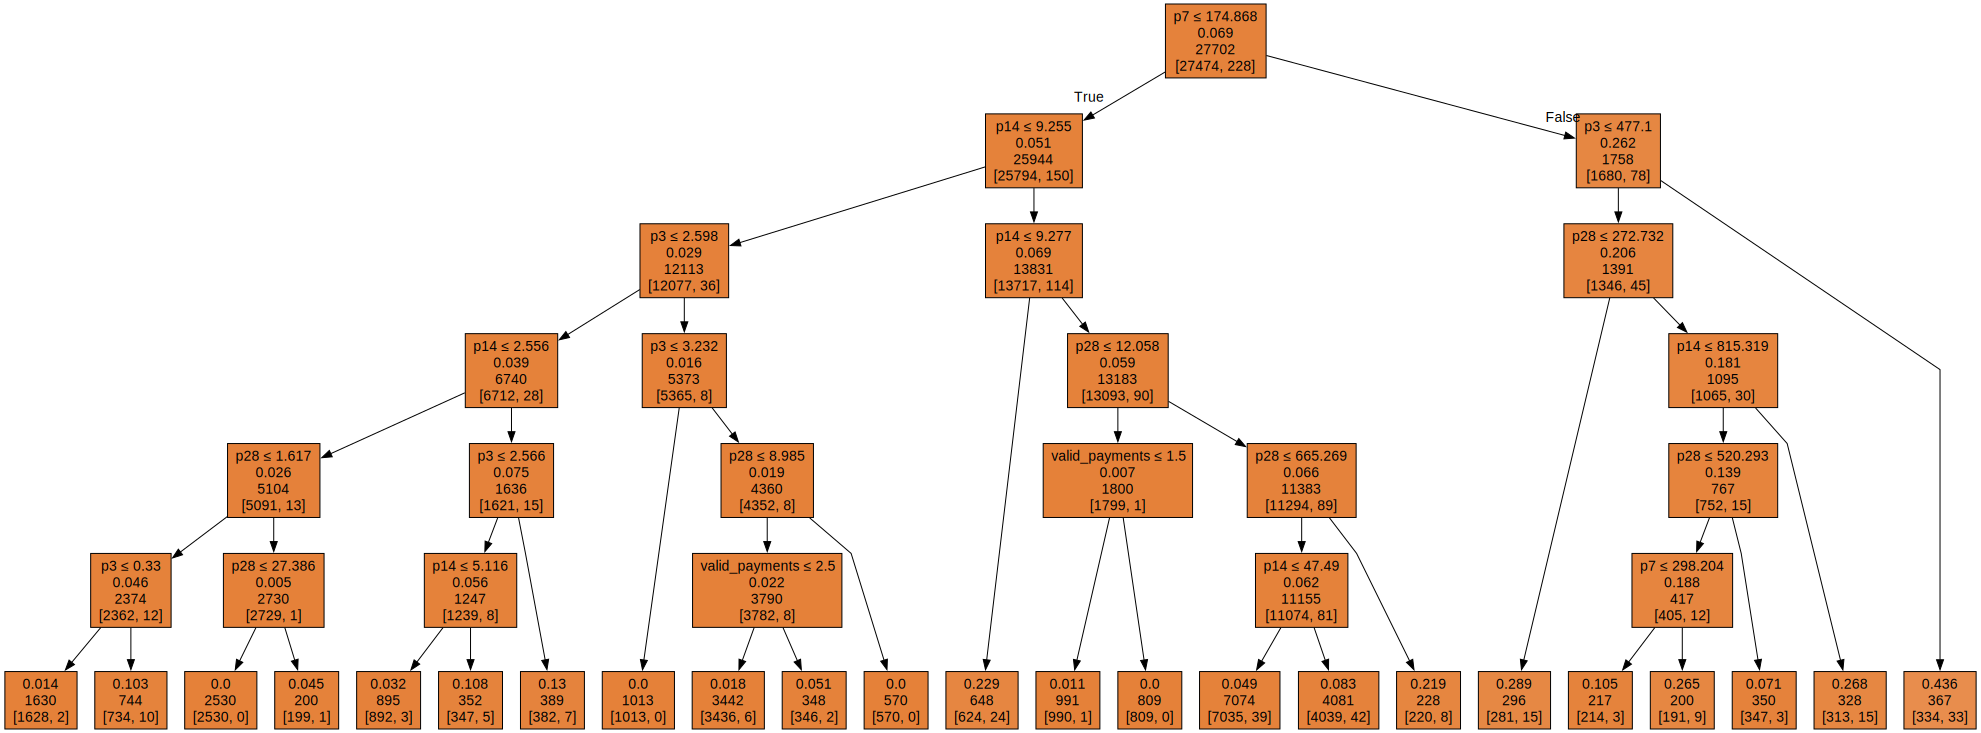

In [31]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# Create the decision tree classifier

# Train the classifier with your data

# Assuming you have your data stored in X_train and y_train
# clf.fit(X_train, y_train)

# Visualize the decision tree
dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = cols
                          #  ,  class_names=True
                           ,  label = 'none'
                           ,  filled = True
                           ,  leaves_parallel = True
                          #  ,  proportion = True
                           ,  rounded = False
                           ,  special_characters = True)

graphviz.Source(dot_data)



# Calibration curves

In [127]:
result['validation_set_id'].unique()[2]

Interval(20240130.0, 20240304.0, closed='right')

In [128]:

train_data =  result[result['validation_set_id'] != result['validation_set_id'].unique()[2]][payment_cols]
test_data =  result[result['validation_set_id'] == result['validation_set_id'].unique()[2]][payment_cols]

X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

X_train.sample(5)

,valid_payments,p3,p7,p14,p28
17411,1,0.00,0.00,0.00,0.00
41731,24,0.00,0.00,0.00,0.00
36097,5,27.96,27.96,46.60,46.60
39458,3,13.44,13.44,13.44,13.44
6749,1,18.74,18.74,18.74,18.74


In [191]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr = LogisticRegression(C=1.0)
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")
Random_Forest = RandomForestClassifier(min_samples_leaf=10)
dt = DecisionTreeClassifier(min_samples_leaf=20)

clf_list = [
    (lr, "Logistic")
    , (gnb, "Naive Bayes")
    # , (gnb_isotonic, "Naive Bayes + Isotonic")
    , (dt, "Classification Tree")
    , (Random_Forest, "Random_Forest", )
]

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- is_dispute
- pred


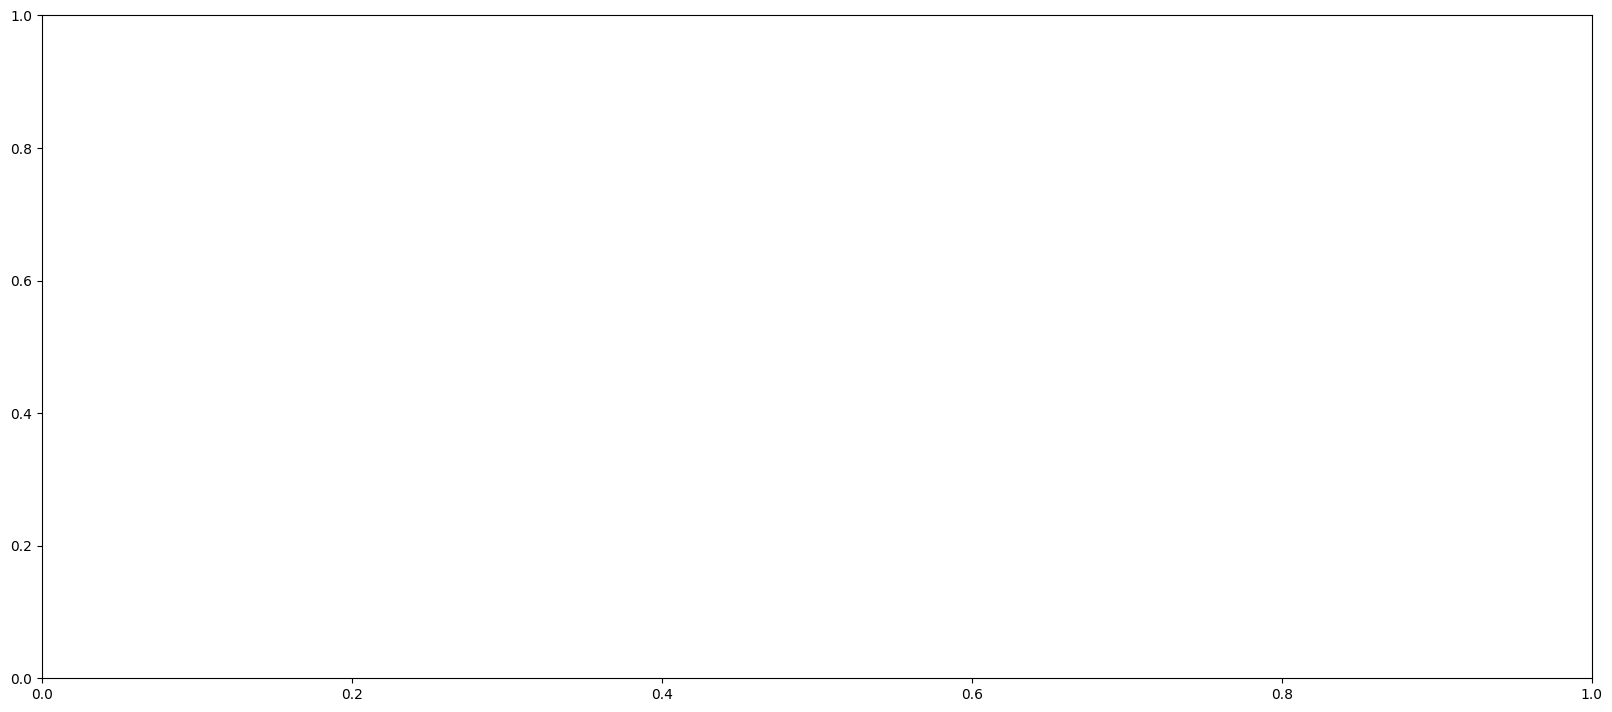

In [192]:
fig = plt.figure(figsize=(20, 18))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=5,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 0.6),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [193]:
Random_Forest.fit(X_train[cols], y_train)
predictions = Random_Forest.predict(X_test[cols])
prob_predictions = Random_Forest.predict_proba(X_test[cols])
accuracy = accuracy_score(y_test, predictions)
prec = precision_score(y_test, predictions)


In [194]:
predictions
prob_predictions[:, 1].max()

0.6098943768361758

In [195]:
from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)

scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- is_dispute
- pred


In [233]:
X_test

,valid_payments,p3,p7,p14,p28
64,1,1.78400,1.78400,1.78400,1.78400
68,16,232.04100,255.29100,277.79900,277.79900
77,7,121.75058,121.75058,121.75058,121.75058
91,1,18.82000,18.82000,18.82000,18.82000
93,15,29.44400,46.59200,51.20200,80.43600
...,...,...,...,...,...
42098,27,0.00000,0.00000,88.12000,228.98000
42111,16,2.72600,125.91600,152.13600,152.13600
42149,1,1.61000,1.61000,1.61000,1.61000
42159,5,0.00000,0.00000,0.00000,84.28000


0.0
0.6098943768361758



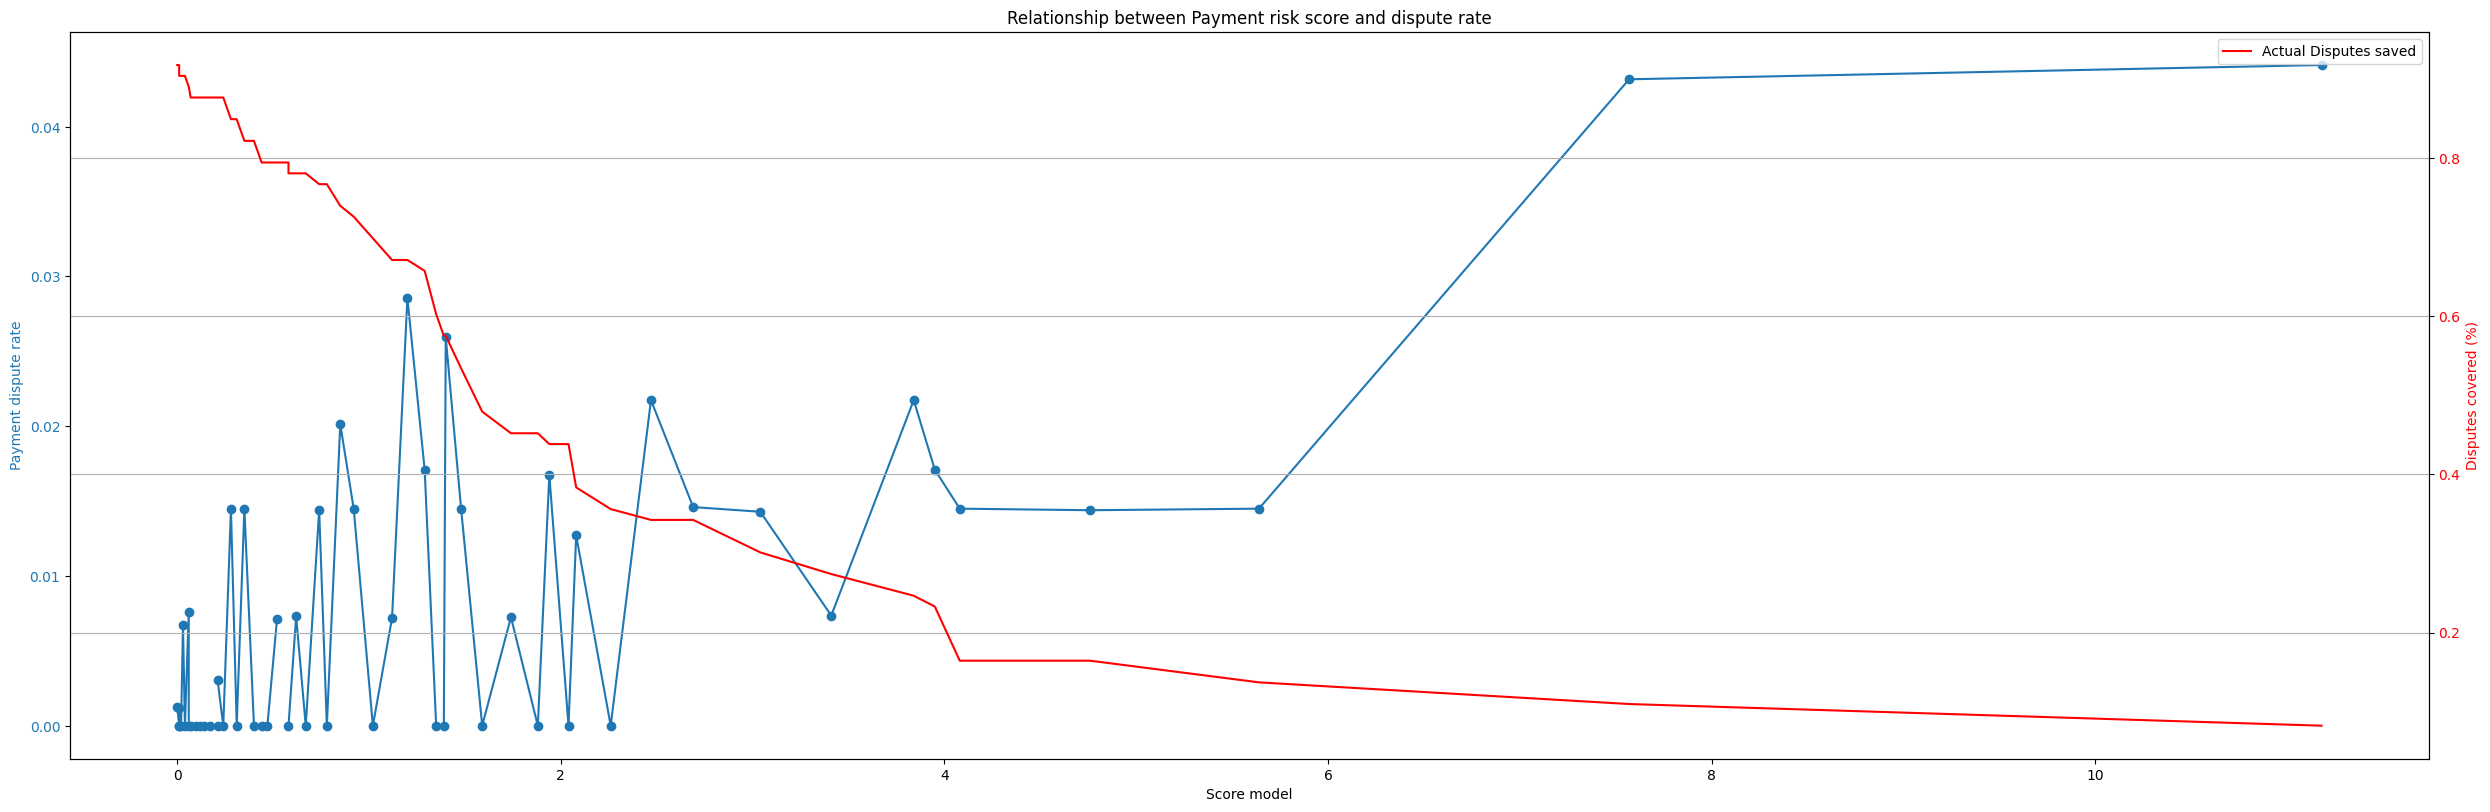

In [197]:

X_test = X_test_old.copy(deep = True)

X_test['pred'] = Random_Forest.predict_proba(X_test[cols])[:, 1] # deleted after run
X_test['is_dispute'] = y_test # deleted after run
print(X_test['pred'].min())
print(X_test['pred'].max())
print('')

# Calculate 200 equally sized groups
quantiles = np.linspace(0, 100, 101)[:-1]  # Generate 200 equally spaced percentiles

# Calculate the actual percentiles
percentiles = np.percentile(X_test['pred'], quantiles)

# Step 1: Calculate the quantiles of 'prob' column
quantiles = X_test['pred'].quantile([i/100 for i in range(1, 101)])

# # Step 2: Calculate the mean of 'is_dispute' for each quantile range
mean_values = []
for i in range(len(quantiles)):

    lower_quantile = quantiles.reset_index(drop = True)[i]

    if i < len(quantiles) - 1:
      upper_quantile = quantiles.reset_index(drop = True)[i + 1]
    else:
      upper_quantile = 100

    subset = X_test[(X_test['pred'] >= lower_quantile) & (X_test['pred'] < upper_quantile)]
    mean_dispute = subset['is_dispute'].mean()
    mean_values.append(mean_dispute)

# Create line plot
x_values = (np.concatenate((percentiles[1:], [lower_quantile]))).round(4)[:-1]
y_values = mean_values[:-1]

# Create a figure and axis for the first plot
fig, ax1 = plt.subplots(figsize = (25, 8))

# Plot the first line on the first Y-axis
color = 'tab:blue'
ax1.set_xlabel('Score model')
ax1.set_ylabel('Payment dispute rate', color=color)
ax1.plot((x_values * 100).round(2), y_values, marker = 'o', color=color)
ax1.tick_params(axis='y', labelcolor = color)

# Create a secondary Y-axis for the second plot
ax2 = ax1.twinx()

quantiles = np.linspace(0, 100, 101)[:-1]  # Generate 200 equally spaced percentiles

# Calculate the actual percentiles
quantiles = np.percentile(X_test['pred'], quantiles)

# Step 2: Calculate average of 'id_dispute' for each quantile
average_id_dispute = []
for quantile in quantiles:
    avg_id_dispute = X_test[X_test['pred'] <= quantile]['is_dispute'].sum()
    average_id_dispute.append(avg_id_dispute)

# Step 3: Create line plot
x_values = (np.concatenate((quantiles[1:], [lower_quantile]))*100).round(2)[:-1]
y_values = 1 - (average_id_dispute/(average_id_dispute[-1]))[:-1]
ax2.plot(x_values, y_values, label = 'Actual Disputes saved', color = 'red')
ax2.set_ylabel('Disputes covered (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc = 0)
del X_test['pred']
del X_test['is_dispute']

fig.tight_layout()
plt.title('Relationship between Payment risk score and dispute rate')
plt.grid(True)
plt.show()


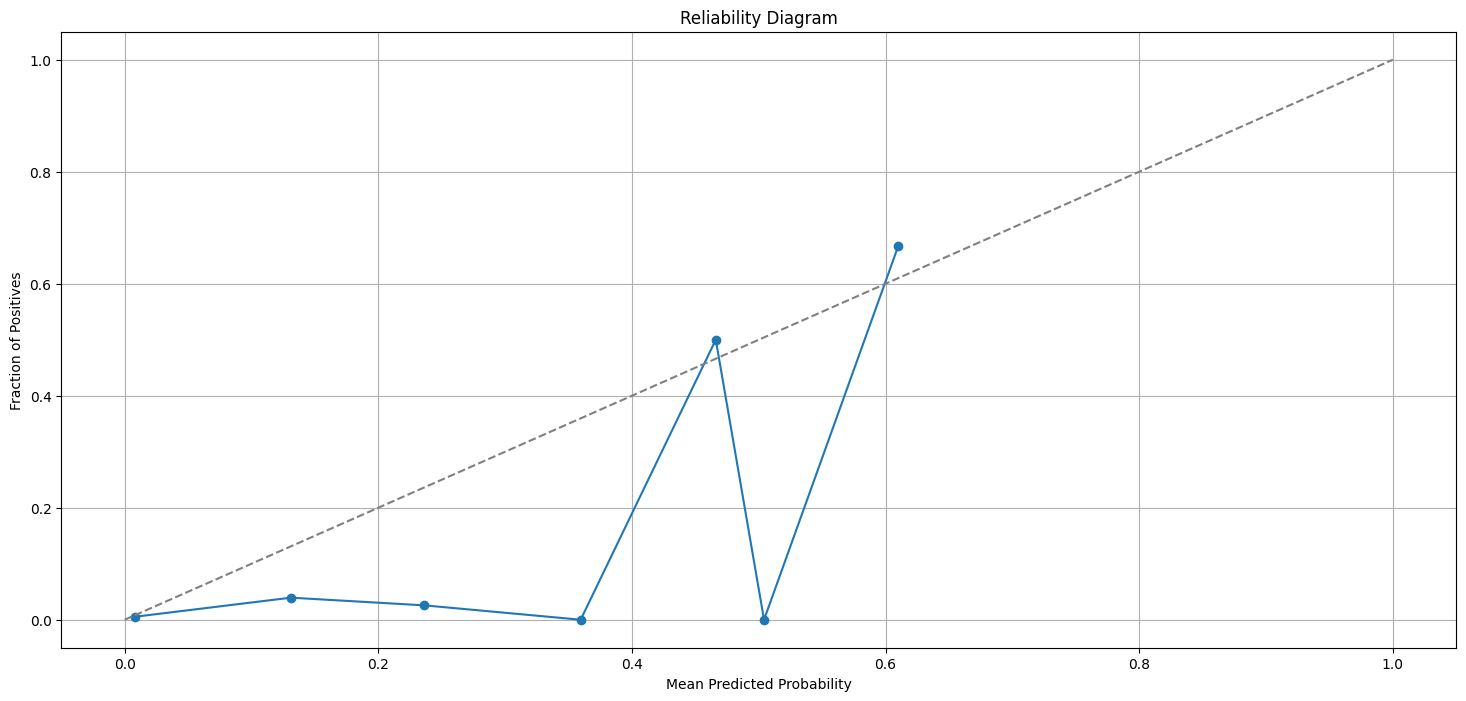

In [198]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

X_test['pred'] = Random_Forest.predict_proba(X_test[cols])[:, 1] # deleted after run
X_test['is_dispute'] = y_test # deleted after run

# Compute calibration curve
prob_true, prob_pred = calibration_curve(X_test['is_dispute'], X_test['pred'] , n_bins=10, strategy='uniform')

# Plot reliability diagram
plt.figure(figsize=(18, 8))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for perfect calibration
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram')
plt.grid(True)
plt.show()


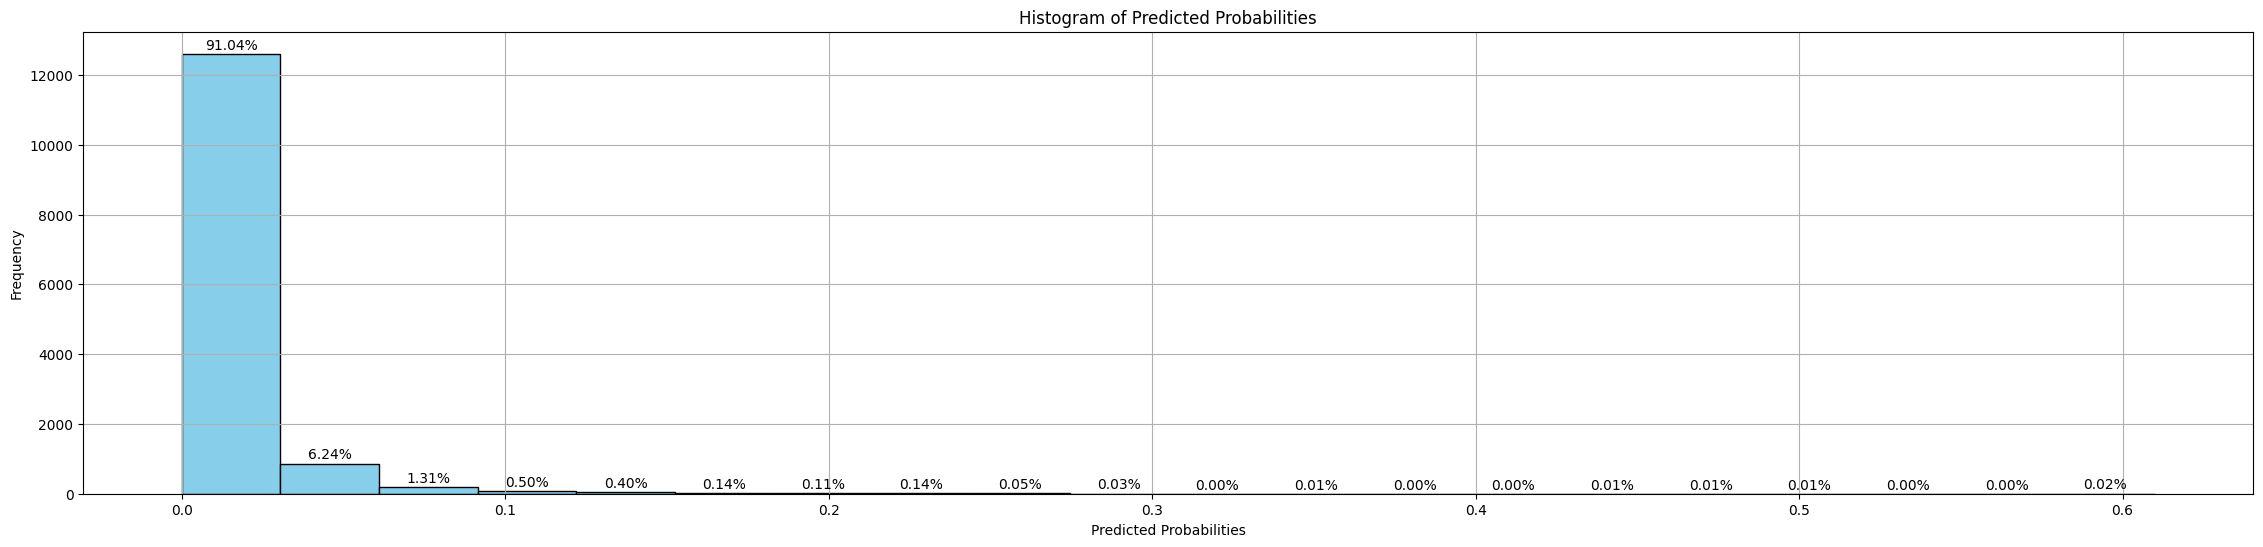

In [200]:
import matplotlib.pyplot as plt

# Assuming X_test['pred'] contains the predicted probabilities
pred_probabilities = X_test['pred']

# Plot histogram
plt.figure(figsize=(28, 6))
n, bins, patches = plt.hist(pred_probabilities, bins=20, color='skyblue', edgecolor='black')

# Compute percentages for each bin
bin_percentages = [(count / len(pred_probabilities)) * 100 for count in n]

# Add labels to bars
for patch, percentage in zip(patches, bin_percentages):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height + 50, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.grid(True)
plt.show()


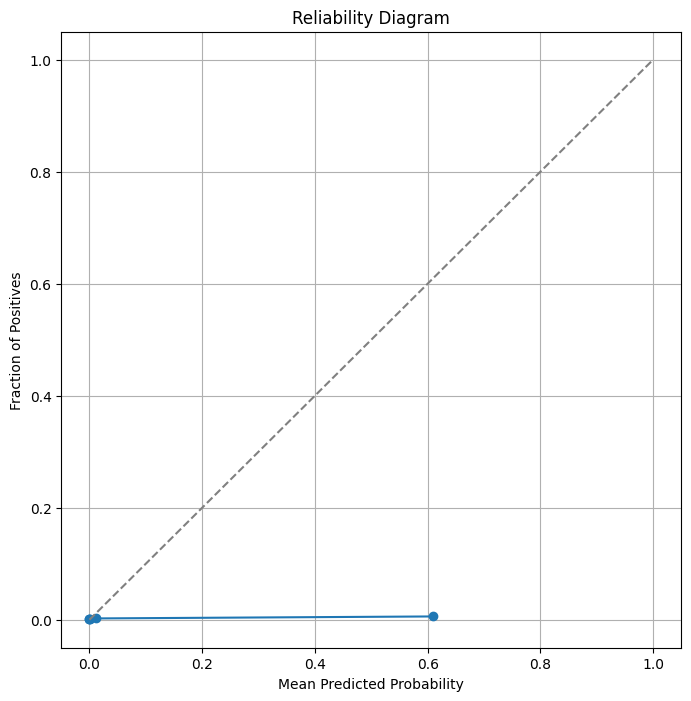

In [201]:
import numpy as np
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Assuming y_true are the true labels and y_prob are the predicted probabilities for the positive class
# Replace ellipsis (...) with your actual validation/test set labels and predicted probabilities
y_true = X_test['is_dispute']
y_prob = X_test['pred']

# Compute quantiles for the predicted probabilities
quantiles = np.linspace(0, 1, num=5)  # Adjust the number of quantiles as needed

# Compute corresponding probabilities at each quantile
prob_pred_quantiles = np.quantile(y_prob, quantiles)

# Compute the mean true probability for each quantile
prob_true_quantiles = []
for q in quantiles:
    indices = np.where(y_prob <= np.quantile(y_prob, q))[0]
    prob_true_quantiles.append(np.mean(y_true.iloc[indices]))  # Use iloc to index by position

# Plot reliability diagram
plt.figure(figsize=(8, 8))
plt.plot(prob_pred_quantiles, prob_true_quantiles, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for perfect calibration
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram')
plt.grid(True)
plt.show()


In [206]:
result

,#account_id,dispute_rate,register_time_x,valid_payments,date,validation_set_id,disputer,cp1,cp3,cp7,...,p42,p49,p5,p56,p6,p7,p91,ph1,ph6,register_time_y
0,10009351,0.0,2023-10-13 05:18:57.000,26,20231013,"(20230901.999, 20240109.0]",0,0,0,0,...,0.00000,0.00000,0.000,0.00000,0.000,0.000,8.05000,0.000,0.000,2023-10-13
1,10108917,0.0,2023-12-14 19:38:29.000,235,20231214,"(20230901.999, 20240109.0]",0,0,0,0,...,470.72963,1166.69363,0.000,2478.39063,0.000,0.000,4100.73289,0.000,0.000,2023-12-15
2,10044978,0.0,2023-11-25 06:01:09.000,87,20231125,"(20230901.999, 20240109.0]",0,0,0,0,...,24.00000,120.03000,0.000,222.82000,0.000,0.000,360.34400,0.000,0.000,2023-11-25
3,10186793,0.0,2023-12-29 14:02:35.000,78,20231229,"(20230901.999, 20240109.0]",0,0,0,25,...,1059.42000,1059.42000,307.762,1059.42000,367.250,367.250,1059.42000,0.000,0.000,2023-12-29
4,10116402,0.0,2023-12-16 03:09:25.000,24,20231216,"(20230901.999, 20240109.0]",0,0,0,0,...,274.60800,274.60800,0.000,274.60800,0.000,0.000,288.53800,0.000,0.000,2023-12-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42201,10442196,0.0,2024-02-08 21:15:22.000,1,20240208,"(20240130.0, 20240304.0]",0,1,1,1,...,2.72600,2.72600,2.726,2.72600,2.726,2.726,2.72600,0.000,0.000,2024-02-09
42202,10299005,0.0,2024-01-16 17:28:42.000,2,20240116,"(20240109.0, 20240130.0]",0,2,2,2,...,10.87000,10.87000,10.870,10.87000,10.870,10.870,10.87000,10.870,10.870,2024-01-17
42203,10394222,0.0,2024-01-31 19:43:35.000,2,20240131,"(20240130.0, 20240304.0]",0,2,2,2,...,3.56800,3.56800,3.568,3.56800,3.568,3.568,3.56800,1.784,1.784,2024-02-01
42204,10401752,0.0,2024-02-02 01:59:45.000,7,20240202,"(20240130.0, 20240304.0]",0,7,7,7,...,42.37000,42.37000,42.370,42.37000,42.370,42.370,42.37000,4.435,4.435,2024-02-02


# Real Cross-Validation 

This part I want to implement a piece of code that breaks the training into multiple parts. Then it predicts and allocates probabilities. Subsequently it generates a visual and reports the metrics that I need to make decisions. 

For example, I want to see the number of users over time. So, I need to do the following: 

1. Break the dataset 
2. Do a model without one piece and calcualte the predictions and the actuals - You can save this 
3. Return the desired metrics - You can save this 
4. plot the results - You can save this 
5. Calcualte the overall metrics. For example, you can calculate the mean metric, and you can plot all the sampled data. 


### Break the dataset 

In [202]:
validation_sets = 3
result['date'] = pd.to_datetime(result['register_time_x']).apply(lambda x: int(x.strftime('%Y%m%d')))
result['validation_set_id'] = pd.qcut(result['date'].values, validation_sets)
# result['validation_set_id'] = 1
result.groupby('validation_set_id').size()


validation_set_id
(20230901.999, 20240109.0]    14504
(20240109.0, 20240130.0]      13850
(20240130.0, 20240304.0]      13852
dtype: int64

In [208]:
result.groupby('validation_set_id')['disputer'].mean()


validation_set_id
(20230901.999, 20240109.0]    0.017788
(20240109.0, 20240130.0]      0.010614
(20240130.0, 20240304.0]      0.005848
Name: disputer, dtype: float64

Warning: The plot belows shows that there is a problem with the data utilised. Overall I think we're considereing to late users and too later payments to obtain dispute rates

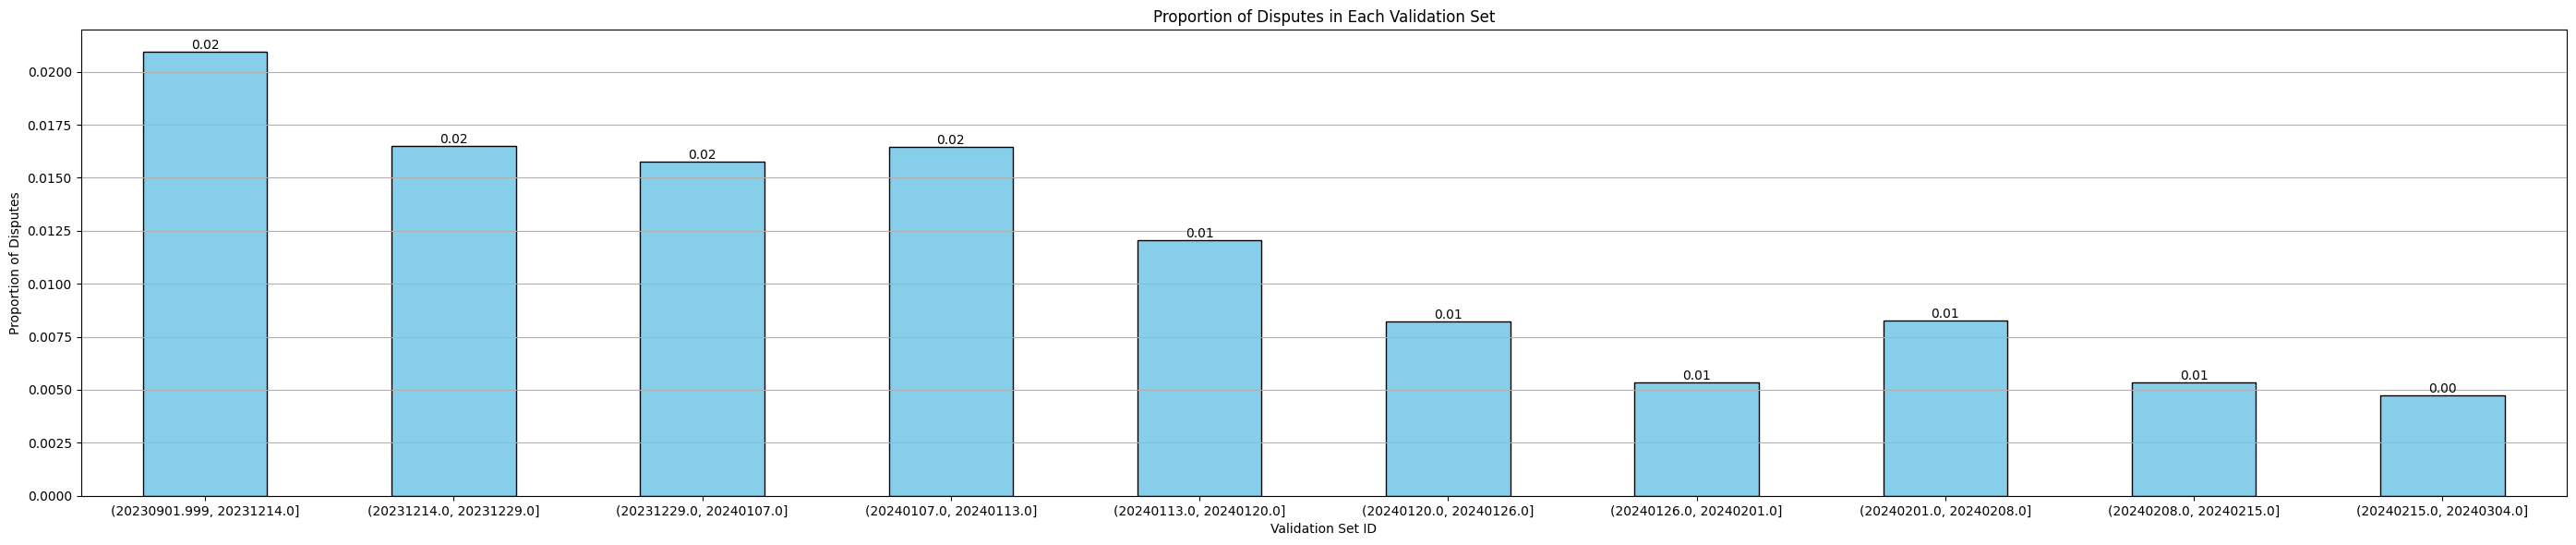

In [216]:
validation_sets = 10

# Convert register_time_x to datetime
result['date'] = pd.to_datetime(result['register_time_x']).apply(lambda x: int(x.strftime('%Y%m%d')))

# Create validation_set_id based on quantiles
result['validation_set_id'] = pd.qcut(result['date'], validation_sets)

# Calculate the proportion of disputes in each group
proportion_disputes = result.groupby('validation_set_id')['disputer'].mean()

# Plot
plt.figure(figsize=(28, 6))
proportion_disputes.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Validation Set ID')
plt.ylabel('Proportion of Disputes')
plt.title('Proportion of Disputes in Each Validation Set')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y')  # Add gridlines only on the y-axis
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Add value labels on top of bars
for i, value in enumerate(proportion_disputes):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()


In [222]:
model.predict_proba(X_test[cols])[:, 1]
result

,#account_id,dispute_rate,register_time_x,valid_payments,date,validation_set_id,disputer,cp1,cp3,cp7,...,p42,p49,p5,p56,p6,p7,p91,ph1,ph6,register_time_y
0,10009351,0.0,2023-10-13 05:18:57.000,26,20231013,"(20230901.999, 20231214.0]",0,0,0,0,...,0.00000,0.00000,0.000,0.00000,0.000,0.000,8.05000,0.000,0.000,2023-10-13
1,10108917,0.0,2023-12-14 19:38:29.000,235,20231214,"(20230901.999, 20231214.0]",0,0,0,0,...,470.72963,1166.69363,0.000,2478.39063,0.000,0.000,4100.73289,0.000,0.000,2023-12-15
2,10044978,0.0,2023-11-25 06:01:09.000,87,20231125,"(20230901.999, 20231214.0]",0,0,0,0,...,24.00000,120.03000,0.000,222.82000,0.000,0.000,360.34400,0.000,0.000,2023-11-25
3,10186793,0.0,2023-12-29 14:02:35.000,78,20231229,"(20231214.0, 20231229.0]",0,0,0,25,...,1059.42000,1059.42000,307.762,1059.42000,367.250,367.250,1059.42000,0.000,0.000,2023-12-29
4,10116402,0.0,2023-12-16 03:09:25.000,24,20231216,"(20231214.0, 20231229.0]",0,0,0,0,...,274.60800,274.60800,0.000,274.60800,0.000,0.000,288.53800,0.000,0.000,2023-12-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42201,10442196,0.0,2024-02-08 21:15:22.000,1,20240208,"(20240201.0, 20240208.0]",0,1,1,1,...,2.72600,2.72600,2.726,2.72600,2.726,2.726,2.72600,0.000,0.000,2024-02-09
42202,10299005,0.0,2024-01-16 17:28:42.000,2,20240116,"(20240113.0, 20240120.0]",0,2,2,2,...,10.87000,10.87000,10.870,10.87000,10.870,10.870,10.87000,10.870,10.870,2024-01-17
42203,10394222,0.0,2024-01-31 19:43:35.000,2,20240131,"(20240126.0, 20240201.0]",0,2,2,2,...,3.56800,3.56800,3.568,3.56800,3.568,3.568,3.56800,1.784,1.784,2024-02-01
42204,10401752,0.0,2024-02-02 01:59:45.000,7,20240202,"(20240201.0, 20240208.0]",0,7,7,7,...,42.37000,42.37000,42.370,42.37000,42.370,42.370,42.37000,4.435,4.435,2024-02-02


In [241]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Create a dictionary of models
models = {
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(),
    'SVC': SVC(probability=True),  # Need to set probability=True for SVC to use predict_proba
    'DecisionTree': DecisionTreeClassifier()
}

# Create an empty list to store results
training_results = []

# Loop through each validation set
for validation_set in result['validation_set_id'].unique(): 

    # Remove it: 
    train_data = result[result['validation_set_id'] != validation_set][payment_cols]
    test_data  = result[result['validation_set_id'] == validation_set][payment_cols]

    # Train and predict with each model
    for model_name, model in models.items():
        X_train, y_train = train_data.drop(columns=['disputer']), train_data['disputer']
        X_test, y_test = test_data.drop(columns=['disputer']), test_data['disputer']
        model.fit(X_train[cols], y_train)
        prob_predictions = model.predict_proba(X_test[cols])[:, 1]

        # Store the predictions along with validation set and model name
        training_results.append(pd.DataFrame({
            'Validation_Set': [validation_set] * len(prob_predictions),
            f'{model_name}_Probability_Predictions': prob_predictions,
            'Actual_Labels': y_test
        }))

# Concatenate all DataFrames into one
training_results = pd.concat(training_results, ignore_index=True)
training_results

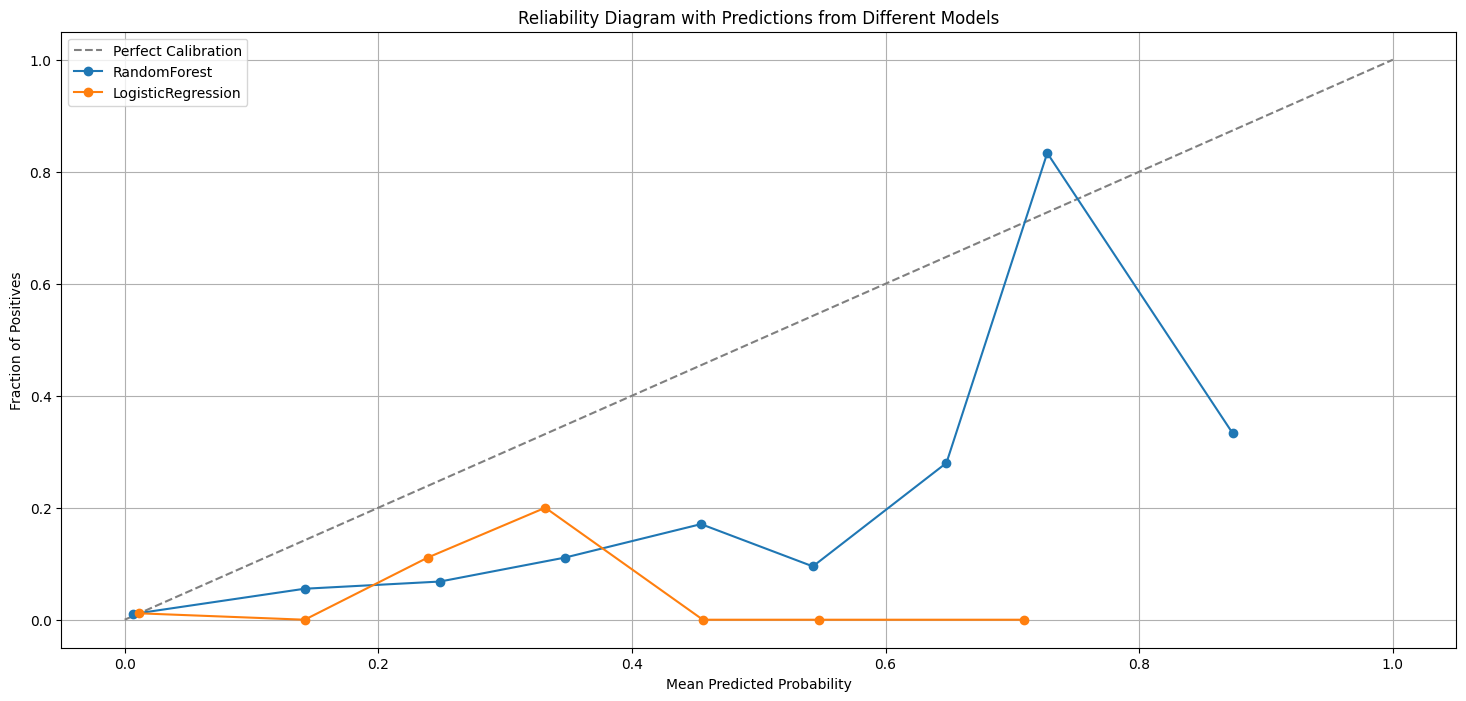

In [ ]:

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Compute calibration curve for each model
plt.figure(figsize=(18, 8))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')  # Diagonal line for perfect calibration

for model_name in models.keys():
    # Extract predictions for the current model
    model_predictions = training_results[f'{model_name}_Probability_Predictions']
    model_actual_labels = training_results['Actual_Labels']
    
    # Compute calibration curve
    prob_true, prob_pred = calibration_curve(model_actual_labels, model_predictions, n_bins=10, strategy='uniform')

    # Plot reliability diagram for the current model
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=model_name)

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram with Predictions from Different Models')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score


model_results = []
all_model_results = []
criteria = ['gini', 'entropy', 'log_loss']
depths = [4,5,6, 7]
leaf_sizes = [200]
cols = ['valid_payments', 'p3', 'p7', 'p14', 'p28']
payment_cols = cols + ['disputer']
# for train_index, test_index in splits:
for date_group in result['validation_set_id'].unique():

    train_data =  result[result['validation_set_id'] != date_group][payment_cols]
    test_data =  result[result['validation_set_id'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
    X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

    # old_cols = X_train.copy().columns
    # X_train = all_feature_enginerring(X_train, y_train)
    # X_test = all_feature_enginerring(X_test, y_test)

    for criterion in tqdm(criteria):

        for depth in depths:

            for leaf_size in leaf_sizes:

              model = create_model(criterion, depth, leaf_size, cols)

              model.fit(X_train[cols], y_train)
              predictions = model.predict(X_test[cols])
              accuracy = accuracy_score(y_test, predictions)
              prec = precision_score(y_test, predictions)
              

              # try:
              #     model.fit(X_train[cols], y_train)
              #     predictions = model.predict(X_test[cols])
              #     accuracy = accuracy_score(y_test, predictions)
              #     prec = precision_score(y_test, predictions)

              # except:
              #     model = np.nan
              #     predictions = np.nan
              #     mae = np.nan
              #     r2 = np.nan

              # Save the model into dictionary (Response, day, mo...)
              model_result = pd.DataFrame({
                  'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)]
                  , 'Test at': [date_group]
                  , 'Model': [model]
                  , 'accuracy': [accuracy]
                  , 'precission': [prec]
                  # , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
              })

              model_results.append(model_result)

    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])